In [1]:
# Importing required libraries :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

# Loading the dataset :
df = pd.read_csv(r"C:\Users\missi\Downloads\youth_data.csv")

# Printing the shape and head
print("Shape of DataFrame:", df.shape)
print("\nFirst 5 rows:\n", df.head())

# Checking data-types
print("\nData types:\n", df.dtypes)

# Checking Missing values :
print("\nMissing (NA) values:\n", df.isna().sum().head(50))

# Checking Unique Values : Which are Numerical and Categorical Features 
print("\nUnique values in 'smoking_status':\n", df.nunique().sort_values())


Shape of DataFrame: (10561, 79)

First 5 rows:
    IRALCFY  IRMJFY  IRCIGFM  IRSMKLSS30N  IRALCFM  IRMJFM  IRCIGAGE  \
0      991     991     91.0           91     91.0    91.0       991   
1      991      60     91.0           91     91.0     2.0       991   
2        1     991     91.0           91     93.0    91.0       991   
3      991     991     91.0           91     91.0    91.0       991   
4      991     991     91.0           91     91.0    91.0       991   

   IRSMKLSSTRY  IRALCAGE  IRMJAGE  ...  EDUSCHLGO  EDUSCHGRD2  EDUSKPCOM  \
0          991       991      991  ...          1           3          0   
1          991       991       14  ...          1           6          0   
2          991        11      991  ...          1           2          1   
3          991       991      991  ...          1           2          0   
4          991       991      991  ...          1           5          0   

   IMOTHER  IFATHER  INCOME  GOVTPROG  POVERTY3  PDEN10  COUTYP4  
0

In [2]:
# Data Cleaning / Processing :

df_cleaned = df.copy()

# Replacing special codes with 0, 1, or NaN
special_vals = {
    'IRSMKLSSTRY': {991: 0},
    'IRMJAGE': {991: 0},
    'IRCIGAGE': {991: 0},
    'IRALCAGE': {991: 0},
    'IRCIGFM': {91: 0, 93: 1},
    'IRALCFM': {91: 0, 93: 1},
    'EDUSKPCOM': {94: np.nan, 97: np.nan, 98: np.nan, 99: np.nan},
    'IRMJFM': {91: 0, 93: 1},
    'IRSMKLSS30N': {91: 0, 93: 1},
    'IRALCFY': {991: 0, 993: 1},
    'IRMJFY': {991: 0, 993: 1}
}

for col, mapping in special_vals.items():
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].replace(mapping)

#Classify columns as categorical or numerical
cat_cols = []
num_cols = []

for col in df_cleaned.columns:
    unique_vals = df_cleaned[col].nunique()
    if unique_vals <= 7 or col == 'EDUSCHGRD2':
        cat_cols.append(col)
    else:
        num_cols.append(col)

# Mean for numerical variables:
for col in num_cols:
    if df_cleaned[col].isna().sum() > 0:
        mean_val = round(df_cleaned[col].mean())
        df_cleaned[col].fillna(mean_val, inplace=True)


# Mode for Categorical Variables
for col in cat_cols:
    if df_cleaned[col].isna().sum() > 0:
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Creation of new Variables :
df_cleaned['EVER_SMOKED'] = np.where(df_cleaned['IRCIGAGE'] == 0, 0, 1)

def recode_cigmdays(val):
    if val in [1, 2]:
        return 'Rarely'
    elif val == 3:
        return 'Occasionally'
    elif val in [4, 5]:
        return 'Frequently'
    elif val == 6:
        return 'None'
    else:
        return np.nan

df_cleaned['CIG_FREQ'] = df_cleaned['CIGMDAYS'].apply(recode_cigmdays)


df_binary = df_cleaned.dropna(subset=['EVER_SMOKED']).drop(columns=['IRCIGAGE', 'CIGMDAYS'])
df_multi = df_cleaned.dropna(subset=['CIG_FREQ']).drop(columns=['IRCIGAGE', 'CIGMDAYS'])
df_reg = df_cleaned.dropna(subset=['IRCIGAGE']).drop(columns=['CIGMDAYS'])


print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))
print("Binary Classification dataset:", df_binary.shape)
print("Multi-Class Classification dataset:", df_multi.shape)
print("Regression dataset:", df_reg.shape)


Categorical columns: 68
Numerical columns: 11
Binary Classification dataset: (10561, 79)
Multi-Class Classification dataset: (10561, 79)
Regression dataset: (10561, 80)


In [3]:
# Checking for Missing values in the dataset
na_check = df_cleaned.isnull().sum()
na_cols =na_check[na_check > 0]
na_cols

Series([], dtype: int64)

In [4]:
df_cleaned.head(20)

,IRALCFY,IRMJFY,IRCIGFM,IRSMKLSS30N,IRALCFM,IRMJFM,IRCIGAGE,IRSMKLSSTRY,IRALCAGE,IRMJAGE,...,EDUSKPCOM,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4,EVER_SMOKED,CIG_FREQ
0,0,0,0.0,0,0.0,0.0,0,0,0,0,...,0.0,1,1,2,2,1,2,2,0,None
1,0,60,0.0,0,0.0,2.0,0,0,0,14,...,0.0,1,1,2,2,1,2,2,0,None
2,1,0,0.0,0,1.0,0.0,0,0,11,0,...,1.0,1,1,4,2,3,1,1,0,None
3,0,0,0.0,0,0.0,0.0,0,0,0,0,...,0.0,1,1,3,2,2,1,1,0,None
4,0,0,0.0,0,0.0,0.0,0,0,0,0,...,0.0,1,1,4,2,3,2,2,0,None
5,0,0,0.0,0,0.0,0.0,0,0,0,0,...,1.0,2,1,3,2,3,1,1,0,None
6,0,0,0.0,0,0.0,0.0,0,0,0,0,...,5.0,1,1,3,1,3,2,2,0,None
7,1,0,0.0,0,1.0,0.0,0,0,12,0,...,10.0,1,2,2,1,1,1,1,0,None
8,0,0,0.0,0,0.0,0.0,0,0,0,0,...,1.0,1,2,3,2,2,1,1,0,None
9,0,0,0.0,0,0.0,0.0,0,0,0,0,...,0.0,1,1,4,2,3,1,1,0,None


In [5]:
df_cleaned.columns

Index(['IRALCFY', 'IRMJFY', 'IRCIGFM', 'IRSMKLSS30N', 'IRALCFM', 'IRMJFM',
       'IRCIGAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'MRJFLAG', 'ALCFLAG',
       'TOBFLAG', 'ALCYDAYS', 'MRJYDAYS', 'ALCMDAYS', 'MRJMDAYS', 'CIGMDAYS',
       'SMKLSMDAYS', 'SCHFELT', 'TCHGJOB', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ',
       'STNDALC', 'STNDDNK', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2',
       'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR', 'YOFIGHT2', 'YOGRPFT2',
       'YOHGUN2', 'YOSELL2', 'YOSTOLE2', 'YOATTAK2', 'PRPKCIG2', 'PRMJEVR2',
       'PRMJMO', 'PRALDLY2', 'YFLPKCG2', 'YFLTMRJ2', 'YFLMJMO', 'YFLADLY2',
       'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2', 'TALKPROB', 'PRTALK3',
       'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2', 'YTHACT2',
       'DRPRVME3', 'ANYEDUC3', 'RLGATTD', 'RLGIMPT', 'RLGDCSN', 'RLGFRND',
       'IRSEX', 'NEWRACE2', 'HEALTH2', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM',
       'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'PDEN10',

In [6]:
correlation = df_cleaned['IRCIGFM'].corr(df_cleaned['IRCIGAGE'])
print("Correlation between IRCIGFM and IRCIGAGE:", correlation)


Correlation between IRCIGFM and IRCIGAGE: 0.4364291753107611


## Q1) Has the Youth Ever Smoked Cigarette or not ?


 Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

 Decision Tree (Tuned) Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2969
           1       0.86      0.25      0.39       200

    accuracy                           0.95      3169
   macro avg       0.91      0.62      0.68      3169
weighted avg       0.95      0.95      0.94      3169

Confusion Matrix:
 [[2961    8]
 [ 150   50]]


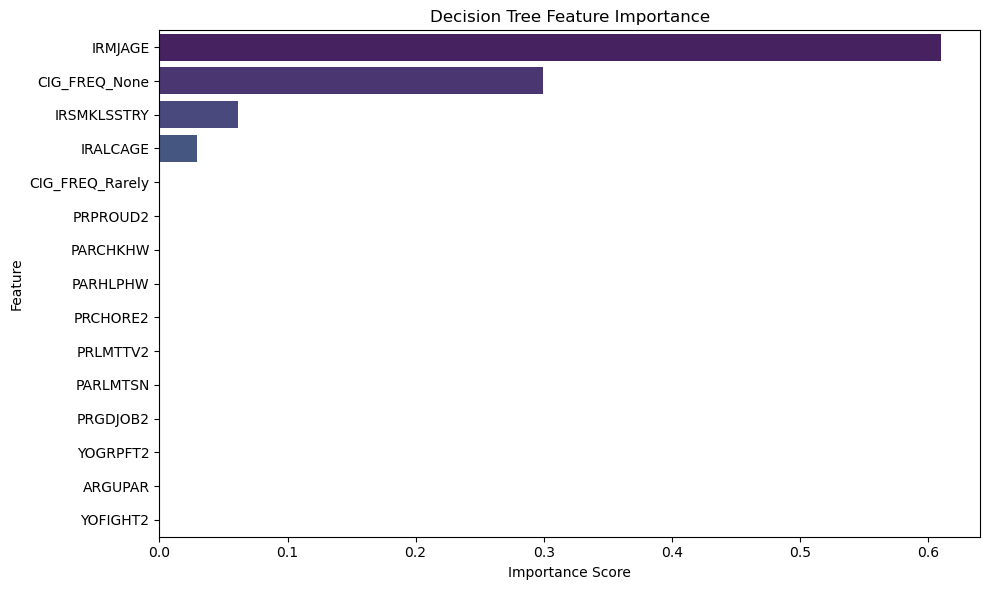

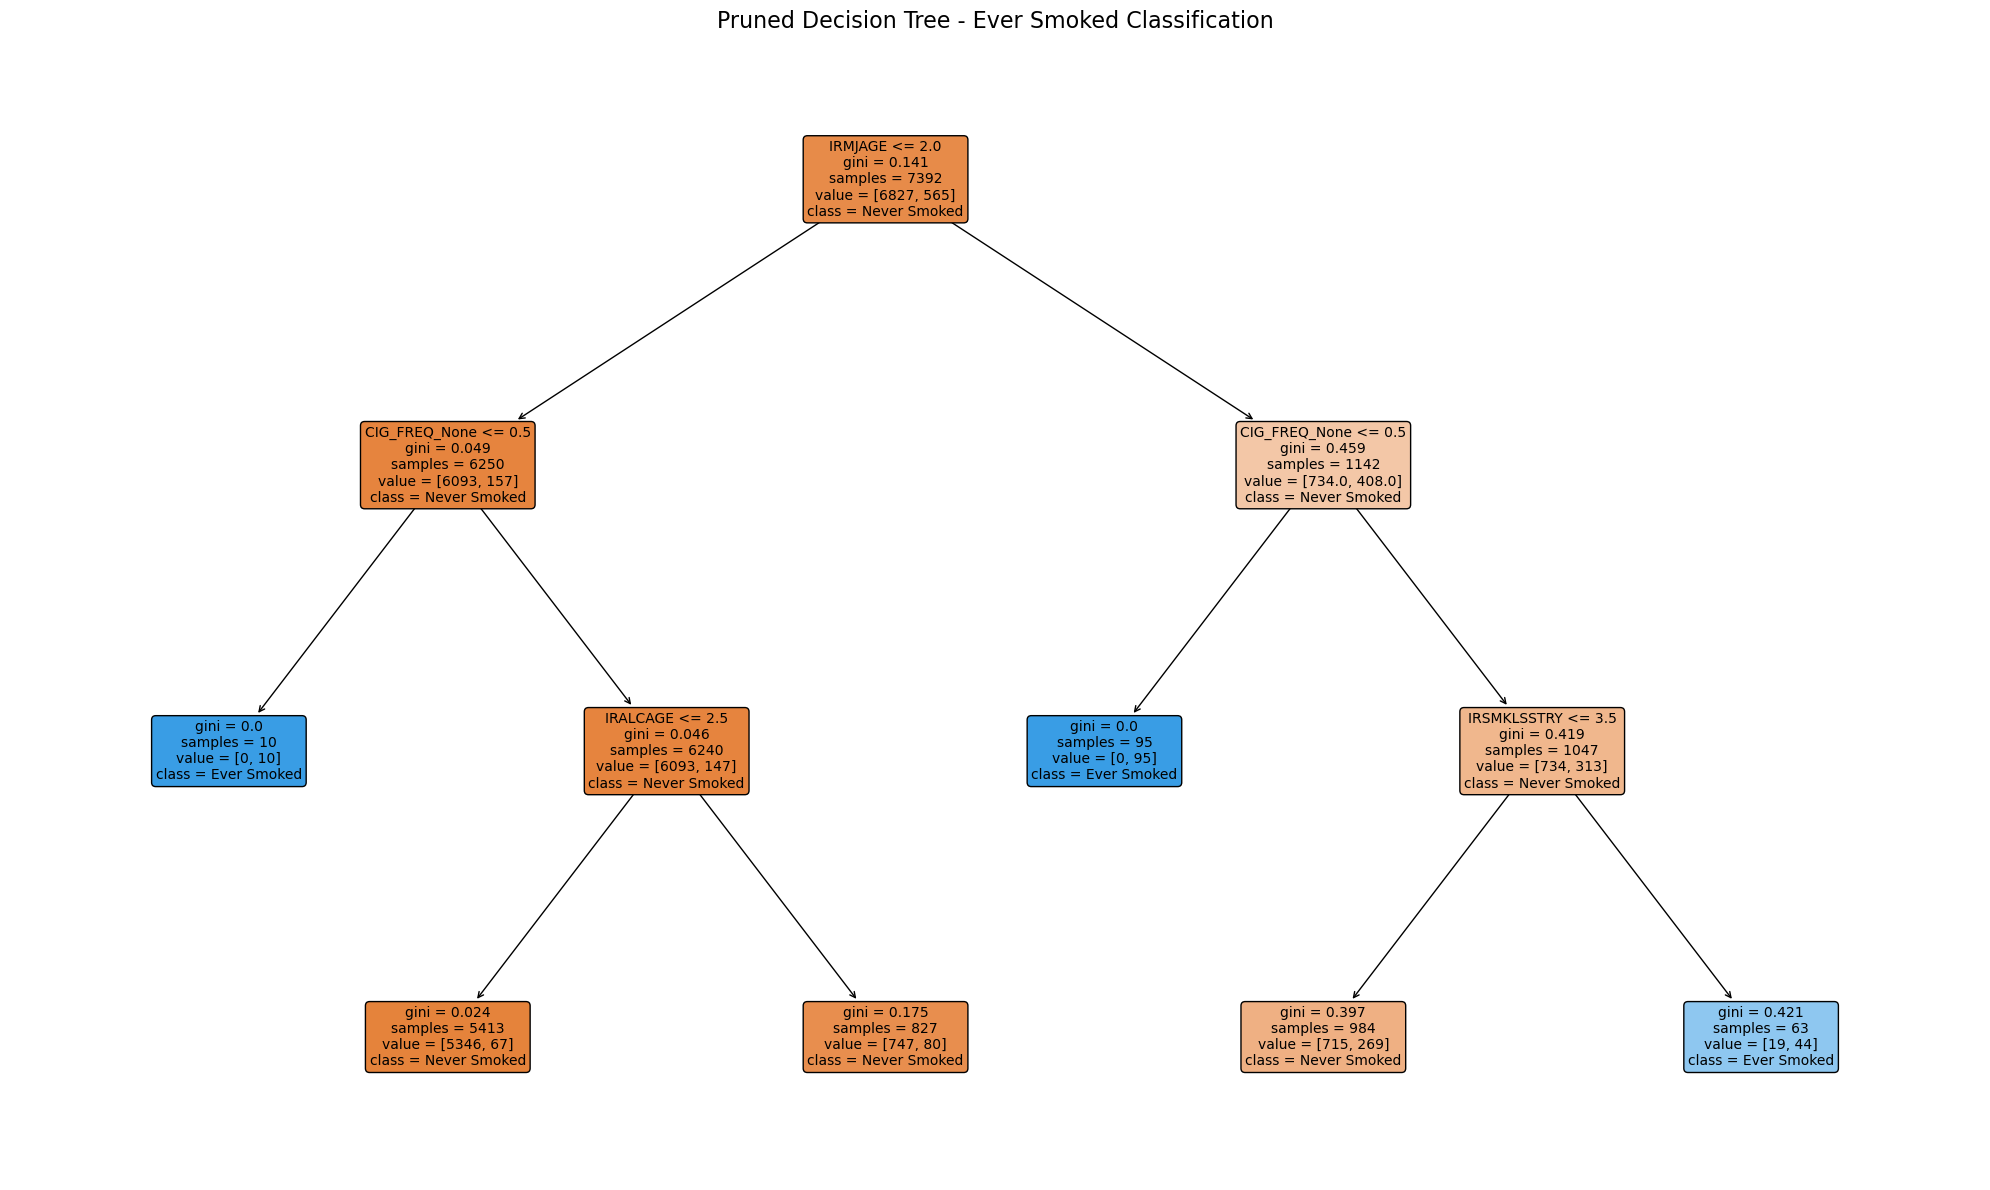


 Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}

 Random Forest (Tuned) Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2969
           1       0.82      0.34      0.49       200

    accuracy                           0.95      3169
   macro avg       0.89      0.67      0.73      3169
weighted avg       0.95      0.95      0.94      3169

Confusion Matrix:
 [[2954   15]
 [ 131   69]]


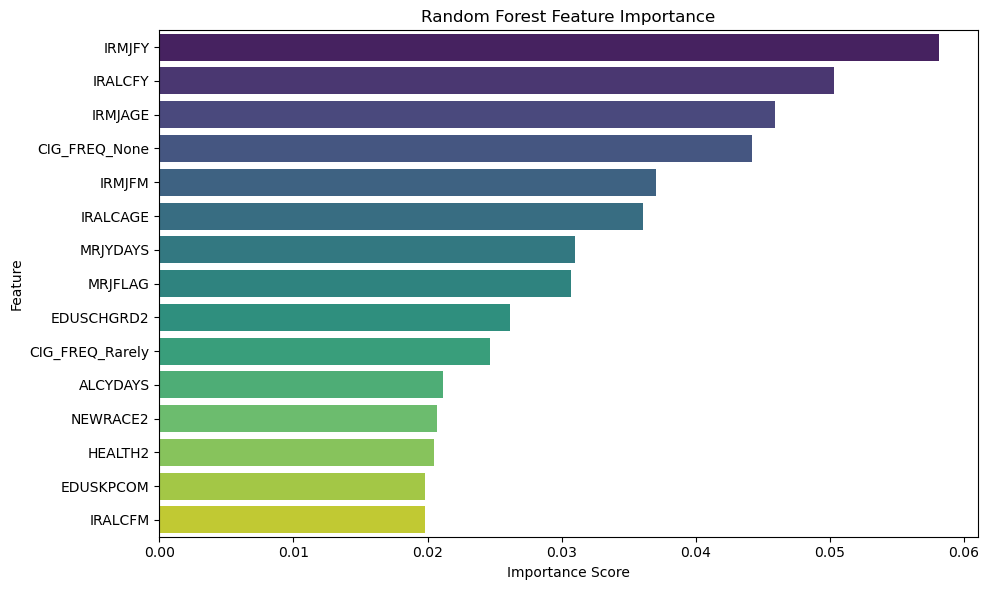

 Best Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

 Boosting (Tuned) Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2969
           1       0.72      0.37      0.49       200

    accuracy                           0.95      3169
   macro avg       0.84      0.68      0.73      3169
weighted avg       0.94      0.95      0.94      3169

Confusion Matrix:
 [[2940   29]
 [ 126   74]]


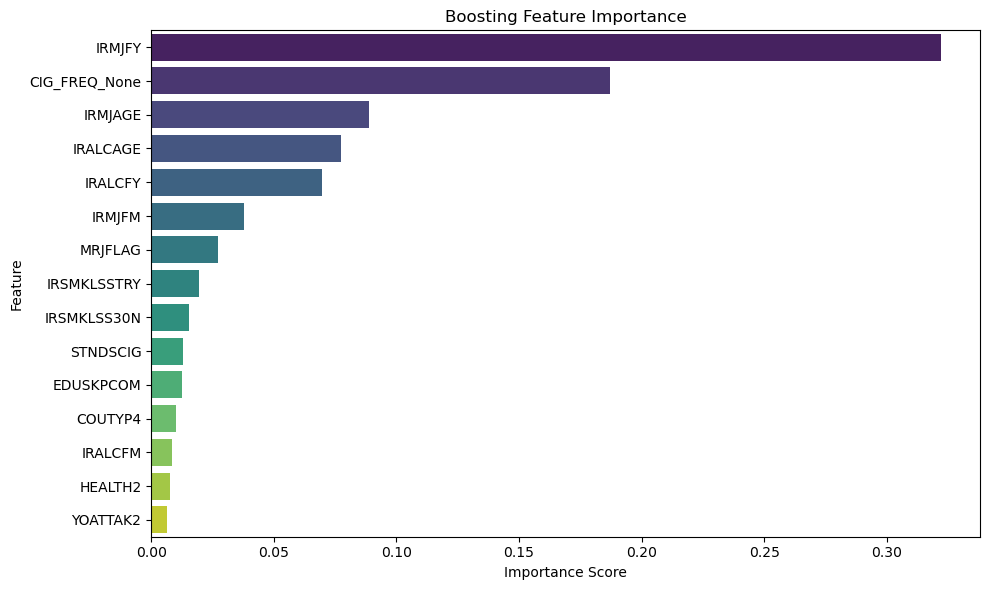

CPU times: total: 19 s
Wall time: 8min 37s


In [8]:
%%time


def evaluate_classification(y_true, y_pred, model_name):
    print(f"\n {model_name} Evaluation:")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

def plot_feature_importance(model, X, title=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:15], y=features[indices][:15], palette="viridis")
    plt.title(title or "Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Binary 
X1 = df_binary.drop(columns=['EVER_SMOKED' , 'IRCIGFM','TOBFLAG'])
y1 = df_binary['EVER_SMOKED']
X1 = pd.get_dummies(X1, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# 1) Basic Tree Classifier :
param_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train) 

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\n Best Decision Tree Params:", grid_dt.best_params_)
evaluate_classification(y_test, y_pred_dt, "Decision Tree (Tuned)")
plot_feature_importance(best_dt, X1, "Decision Tree Feature Importance")
plt.show()

from sklearn.tree import plot_tree

# Pruned Plot :
plt.figure(figsize=(20, 12))
plot_tree(
    best_dt,
    feature_names=X1.columns,
    class_names=["Never Smoked", "Ever Smoked"],  # Correct class names
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  
)
plt.title("Pruned Decision Tree - Ever Smoked Classification", fontsize=16)
plt.tight_layout()
plt.show()


# 2) Random Forest

param_rf = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5, 10, None],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\n Best Random Forest Params:", grid_rf.best_params_)
evaluate_classification(y_test, y_pred_rf, "Random Forest (Tuned)")
plot_feature_importance(best_rf, X1, "Random Forest Feature Importance")


# 3) Gradient Boosting

param_boost = {
    'n_estimators': [100,200,300],
    'learning_rate': [0.05, 0.1,0.3,0.5],
    'max_depth': [3, 5,7]
}
grid_boost = GridSearchCV(GradientBoostingClassifier(random_state=42), param_boost, cv=5, scoring='accuracy', n_jobs=-1)
grid_boost.fit(X_train, y_train)

best_boost = grid_boost.best_estimator_
y_pred_boost = best_boost.predict(X_test)

print(" Best Boosting Params:", grid_boost.best_params_)
evaluate_classification(y_test, y_pred_boost, "Boosting (Tuned)")
plot_feature_importance(best_boost, X1, "Boosting Feature Importance")


In [9]:
%%time

# Binary Classification Comparison :

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models_binary = {
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Boosting": y_pred_boost
}


results_binary = []

for model_name, y_pred in models_binary.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results_binary.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

df_results_binary = pd.DataFrame(results_binary).sort_values(by="F1 Score", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_results_binary["Model"], df_results_binary["F1 Score"], color='green')
plt.title("Binary Classification: F1 Score Comparison", fontsize=14)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


CPU times: total: 125 ms
Wall time: 108 ms


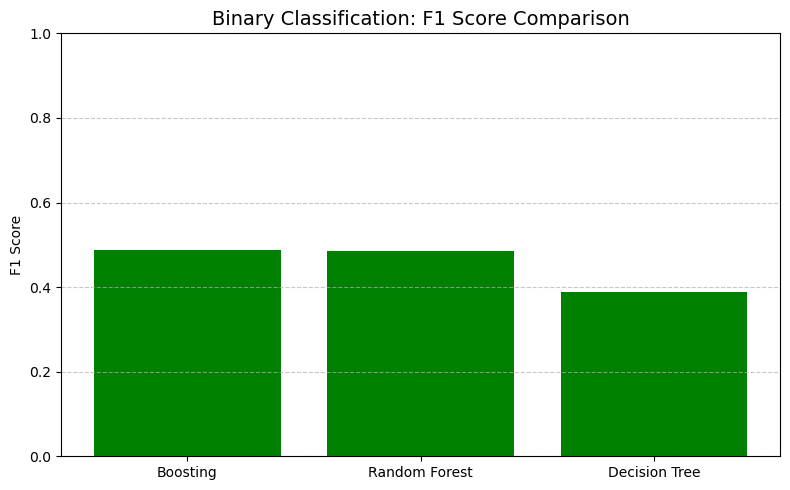

## Q2) Multi-Class Classification : How Frequently does the Youth smoke Cigarette?


Decision Tree - Best Parameters: {'max_depth': 5, 'min_samples_split': 2}

--- Decision Tree (Tuned) Evaluation ---
Accuracy: 0.9854843799305775
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      0.99      3128
           2       0.00      0.00      0.00         2
           3       0.27      0.09      0.13        35

    accuracy                           0.99      3169
   macro avg       0.32      0.27      0.28      3169
weighted avg       0.98      0.99      0.98      3169



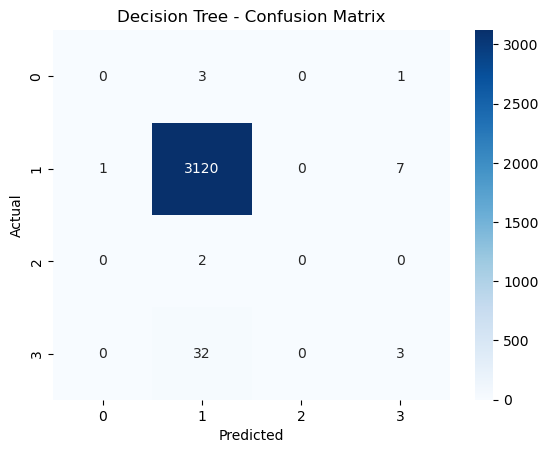

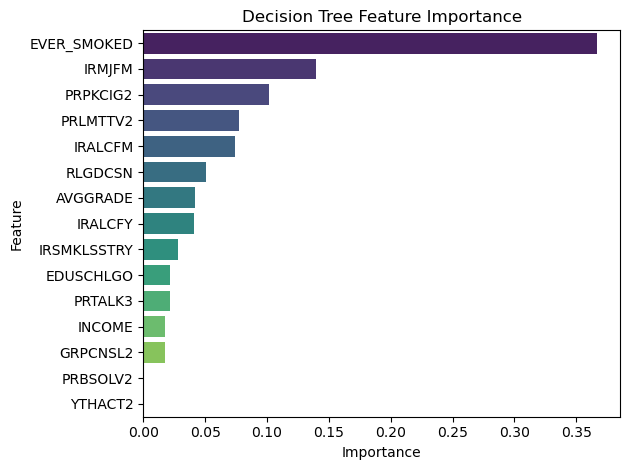


Bagging - Best Parameters: {'estimator__max_depth': None, 'n_estimators': 100}

--- Bagging (Tuned) Evaluation ---
Accuracy: 0.987062164720732
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      0.99      3128
           2       0.00      0.00      0.00         2
           3       0.33      0.03      0.05        35

    accuracy                           0.99      3169
   macro avg       0.33      0.26      0.26      3169
weighted avg       0.98      0.99      0.98      3169



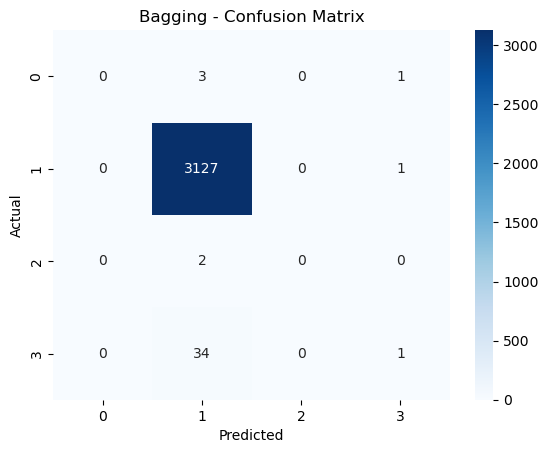


Random Forest - Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}

--- Random Forest (Tuned) Evaluation ---
Accuracy: 0.987062164720732
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      0.99      3128
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        35

    accuracy                           0.99      3169
   macro avg       0.25      0.25      0.25      3169
weighted avg       0.97      0.99      0.98      3169



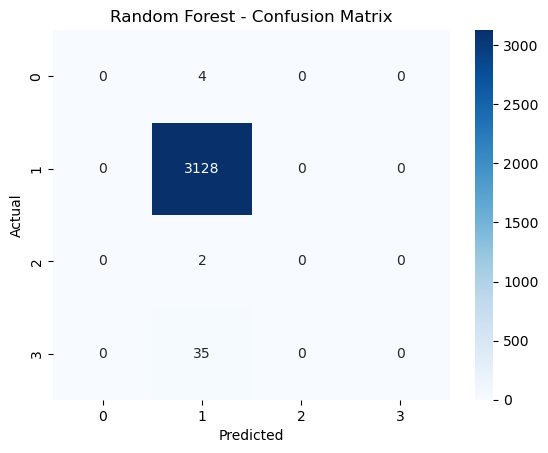

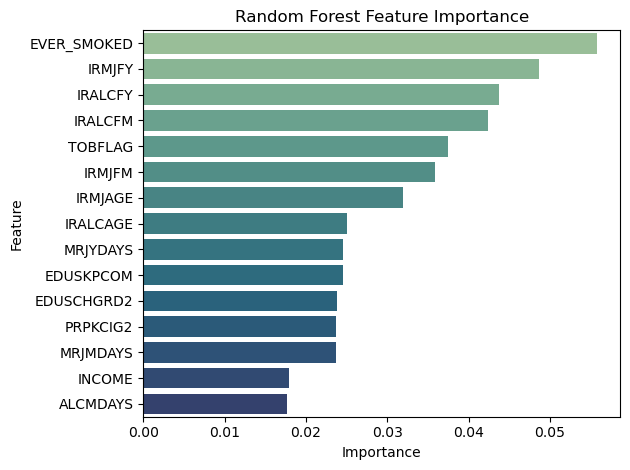


Gradient Boosting - Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

--- Gradient Boosting (Tuned) Evaluation ---
Accuracy: 0.9845377090564847
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      0.99      3128
           2       0.00      0.00      0.00         2
           3       0.08      0.03      0.04        35

    accuracy                           0.98      3169
   macro avg       0.27      0.26      0.26      3169
weighted avg       0.98      0.98      0.98      3169



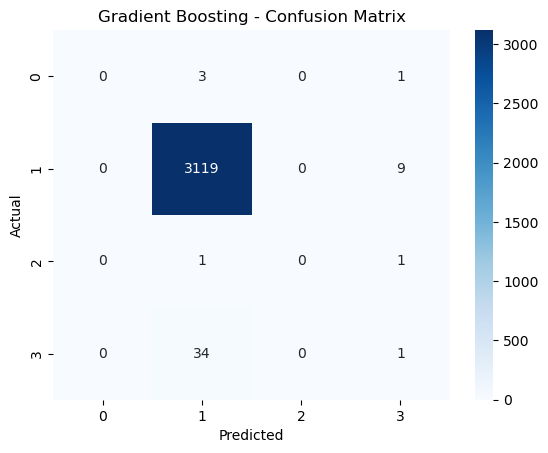

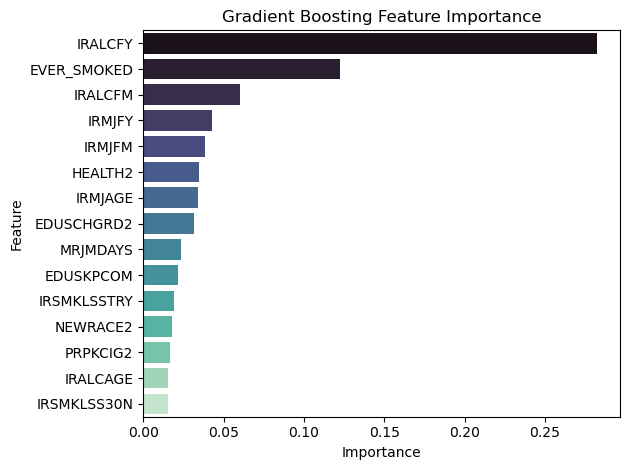

In [11]:
# MULTI - CLASS 
X2 = df_multi.drop(columns=['CIG_FREQ', 'IRCIGFM'])
y2 = df_multi['CIG_FREQ']
X2 = pd.get_dummies(X2, drop_first=True)

le2 = LabelEncoder()
y2_encoded = le2.fit_transform(y2)

X_train, X_test, y_train, y_test = train_test_split(X2, y2_encoded, test_size=0.3, random_state=42)


# 1. Decision Tree

param_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2,3,5]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=5, n_jobs=-1, scoring='accuracy')
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("\nDecision Tree - Best Parameters:", grid_dt.best_params_)

y_pred_dt = best_dt.predict(X_test)
print("\n--- Decision Tree (Tuned) Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

feat_imp_dt = pd.Series(best_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_dt[:15], y=feat_imp_dt.index[:15], palette='viridis')
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# 2. Bagging

param_bag = {
    'n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 5, 7, 10]
}
bag_base = DecisionTreeClassifier(random_state=42)
bag_model = BaggingClassifier(estimator=bag_base, random_state=42)
grid_bag = GridSearchCV(bag_model, param_bag, cv=5, n_jobs=-1, scoring='accuracy')
grid_bag.fit(X_train, y_train)

best_bag = grid_bag.best_estimator_
print("\nBagging - Best Parameters:", grid_bag.best_params_)

y_pred_bag = best_bag.predict(X_test)
print("\n--- Bagging (Tuned) Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))
sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Blues')
plt.title("Bagging - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




# 3. Gradient Boosting

param_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7]
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gb, cv=5, n_jobs=-1, scoring='accuracy')
grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_
print("\nGradient Boosting - Best Parameters:", grid_gb.best_params_)

y_pred_gb = best_gb.predict(X_test)
print("\n--- Gradient Boosting (Tuned) Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

feat_imp_gb = pd.Series(best_gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_gb[:15], y=feat_imp_gb.index[:15], palette='mako')
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Q3) At what age did the Youth Smoke their First Cigarette ?

 Decision Tree Regressor (Tuned)
Best Parameters: {'max_depth': 5, 'min_samples_split': 5}
RMSE: 1.7637681242668217
MAE: 0.37321737486392215
R² Score: 0.6863196814844241


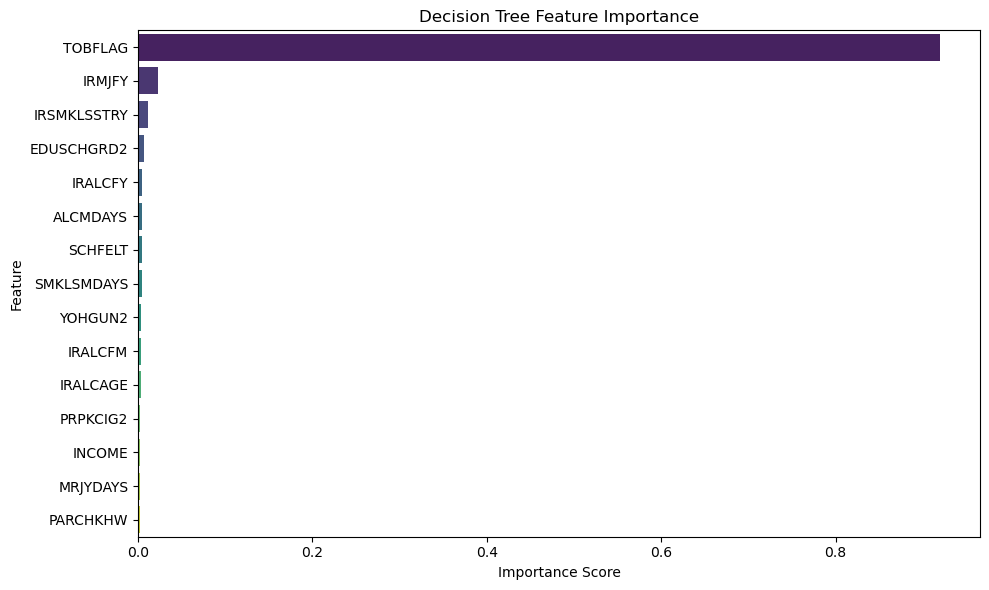

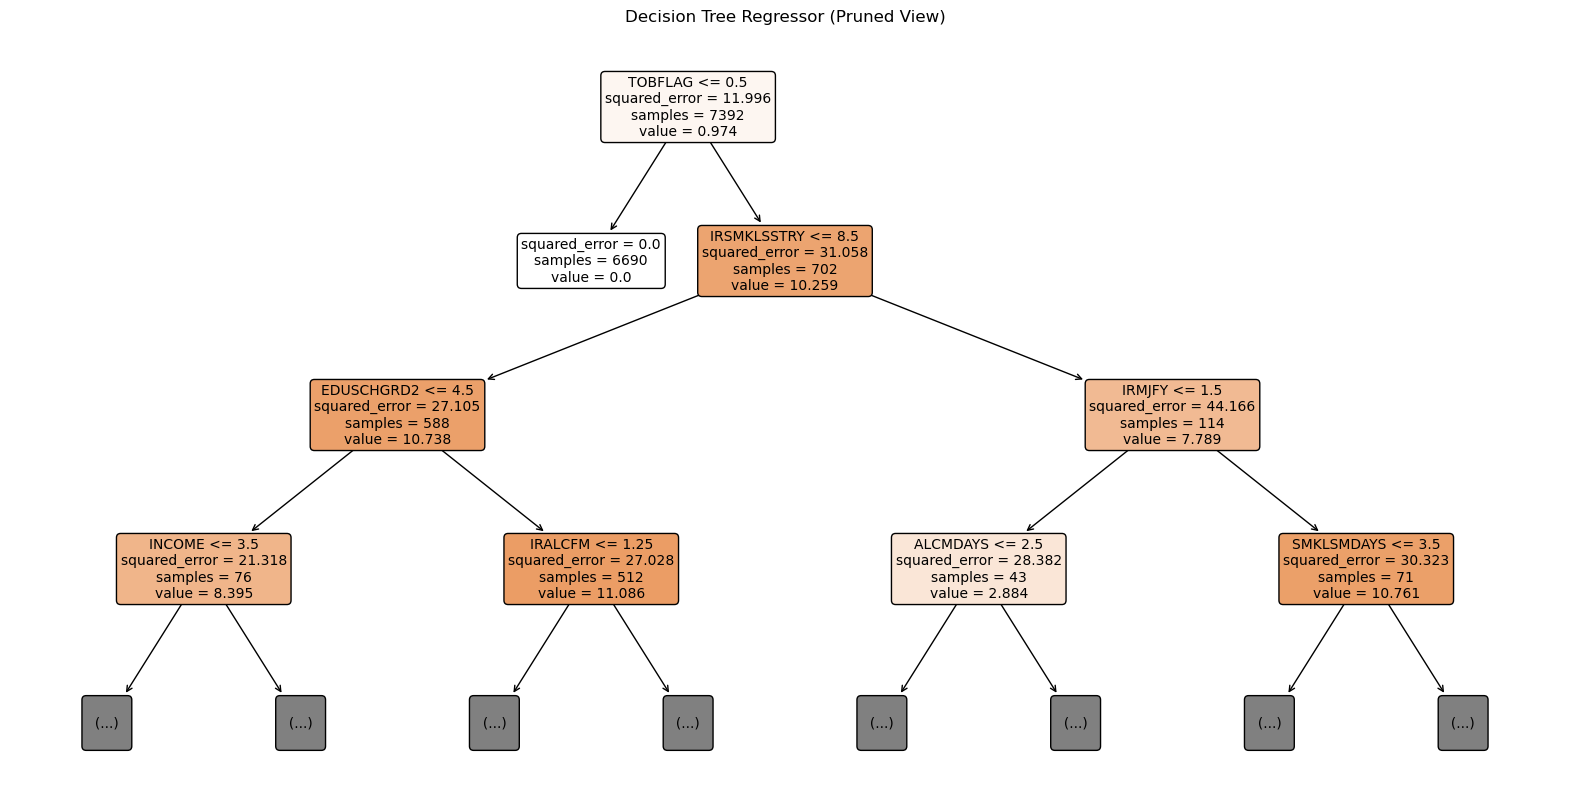


 Bagging Regressor (Tuned)
Best Parameters: {'estimator__max_depth': 5, 'n_estimators': 300}
RMSE: 1.5532975039093722
MAE: 0.3493799875314551
R² Score: 0.7567159819788709

 Random Forest Regressor (Tuned)
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
RMSE: 1.6671877485620827
MAE: 0.5602524455664247
R² Score: 0.7197321308887437


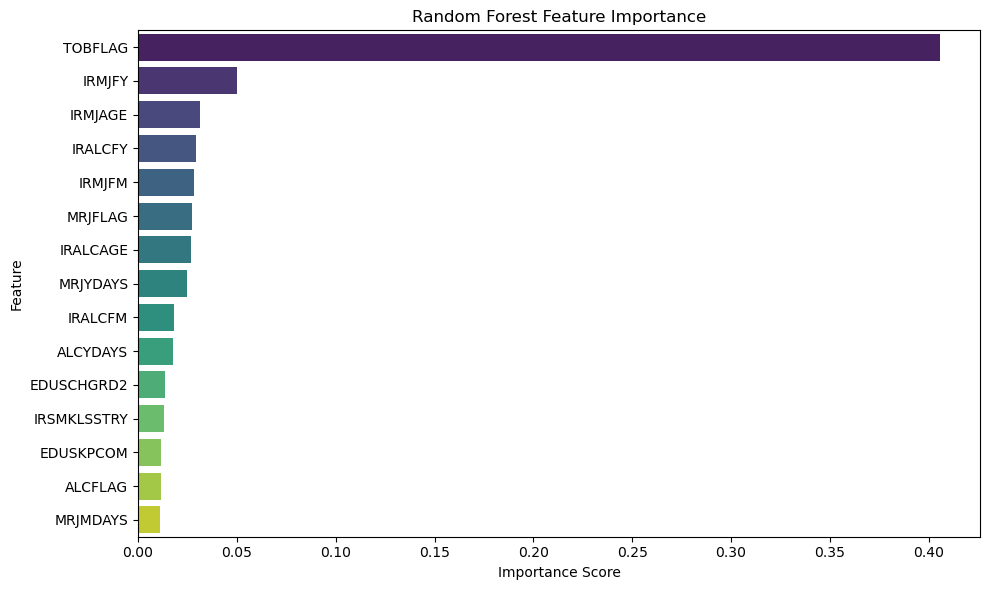

CPU times: total: 10.3 s
Wall time: 1min 59s


In [75]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Xr = df_reg.drop(columns=['IRCIGAGE', 'CIG_FREQ','EVER_SMOKED','IRCIGFM'])   
yr = df_reg['IRCIGAGE']

Xr = pd.get_dummies(Xr, drop_first=True)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Xr, yr, test_size=0.3, random_state=42)


# 1. Decision Tree Regressor 

dt_reg = DecisionTreeRegressor(random_state=42)
param_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(dt_reg, param_dt, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_dt.fit(X_train_r, y_train_r)

# Best model
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_r)

print(" Decision Tree Regressor")
print("Best Parameters:", grid_dt.best_params_)
print("RMSE:", mean_squared_error(y_test_r, y_pred_dt, squared=False))
print("MAE:", mean_absolute_error(y_test_r, y_pred_dt))
print("R² Score:", r2_score(y_test_r, y_pred_dt))

plot_feature_importance(best_dt, X_train_r, "Decision Tree Feature Importance")

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))  
plot_tree(
    best_dt,
    feature_names=X_train_r.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  
)
plt.title("Decision Tree Regressor: Pruned")
plt.show()



# 2. Bagging Regressor 

from sklearn.ensemble import BaggingRegressor

bag_base = DecisionTreeRegressor(random_state=42)
bag_reg = BaggingRegressor(estimator=bag_base, random_state=42)

param_bag = {
    'n_estimators': [100,200,300],
    'estimator__max_depth': [None, 5, 7, 10]
}

grid_bag = GridSearchCV(bag_reg, param_bag, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_bag.fit(X_train_r, y_train_r)

best_bag = grid_bag.best_estimator_
y_pred_bag = best_bag.predict(X_test_r)

print("\n Bagging Regressor")
print("Best Parameters:", grid_bag.best_params_)
print("RMSE:", mean_squared_error(y_test_r, y_pred_bag, squared=False))
print("MAE:", mean_absolute_error(y_test_r, y_pred_bag))
print("R² Score:", r2_score(y_test_r, y_pred_bag))



# 3.Random Forest Regressor 


from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)

param_rf = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 5, 7, 10],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(rf_reg, param_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_r, y_train_r)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_r)

print("\n Random Forest Regressor ")
print("Best Parameters:", grid_rf.best_params_)
print("RMSE:", mean_squared_error(y_test_r, y_pred_rf, squared=False))
print("MAE:", mean_absolute_error(y_test_r, y_pred_rf))
print("R² Score:", r2_score(y_test_r, y_pred_rf))

plot_feature_importance(best_rf, X_train_r, "Random Forest Feature Importance")


           Model       MAE      RMSE  R² Score
1        Bagging  0.347056  1.541331  0.760450
2  Random Forest  0.348930  1.550225  0.757678
0  Decision Tree  0.439886  2.159614  0.529720


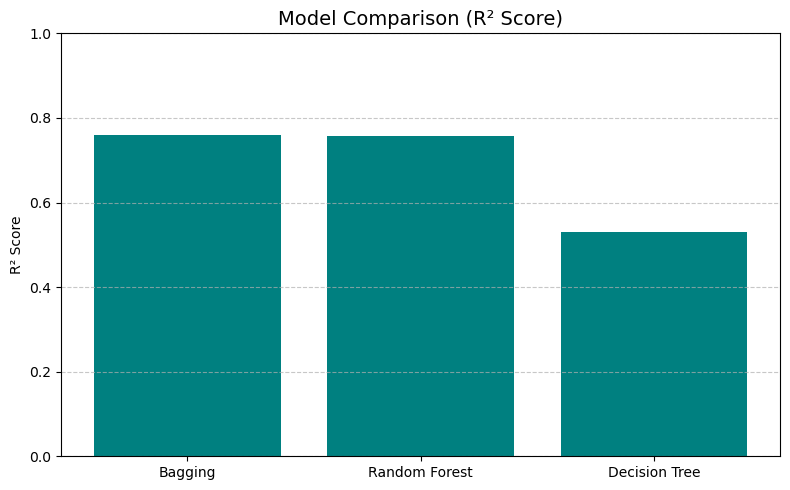

In [14]:

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Bagging": BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    
}

# Stores results
results = []

for name, model in models.items():
    model.fit(X_train_r, y_train_r)
    y_pred = model.predict(X_test_r)
    
    mae = mean_absolute_error(y_test_r, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred))
    r2 = r2_score(y_test_r, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R² Score": r2
    })


results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)

print(results_df)


plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["R² Score"], color='teal')
plt.title("Model Comparison (R² Score)", fontsize=14)
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
